In [5]:
import numpy as np
import pandas as pd
import pandas_datareader as web
import matplotlib.pyplot as plt
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

import warnings
warnings.filterwarnings('ignore')

In [62]:
df2017 = pd.read_csv('data/2017/AAPL.csv')
df2018 = pd.read_csv('data/2018/AAPL.csv')
df2019 = pd.read_csv('data/2019/AAPL.csv')

df = pd.concat([df2017, df2018, df2019])
df['date'] = [x[:-6] for x in df['date'].to_list()]
df['date'] = pd.to_datetime(df['date'], format = "%Y-%m-%d %H:%M:%S")
df = df.set_index(pd.DatetimeIndex(df['date']))

df = df.drop(['date', 'otc'], axis = 1)

In [78]:
data = df.resample('D').agg({'open': 'first', 'high' : 'max', 'low' : 'min', 'close' : 'last', 'volume': 'sum'}).dropna()

In [79]:
data.head(2)

,open,high,low,close,volume
date,,,,,
2017-01-03,28.9500,29.0825,28.6900,29.0225,102572716.0
2017-01-04,28.9625,29.1275,28.9375,29.0025,74946512.0


In [66]:
scaler = MinMaxScaler(feature_range=(0, 1))

scaled_data = scaler.fit_transform(data['close'].values.reshape(-1, 1))

In [67]:
prediction_days = 90

In [68]:
x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])

In [69]:
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [70]:
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))  ## Prediction of the next closing price

model.compile(optimizer='Adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=25, batch_size=32)

Epoch 1/25
21/21 [==============================] - 8s 91ms/step - loss: 0.0384
Epoch 2/25
21/21 [==============================] - 2s 86ms/step - loss: 0.0092
Epoch 3/25
21/21 [==============================] - 2s 90ms/step - loss: 0.0055
Epoch 4/25
21/21 [==============================] - 2s 97ms/step - loss: 0.0050
Epoch 5/25
21/21 [==============================] - 2s 85ms/step - loss: 0.0041
Epoch 6/25
21/21 [==============================] - 2s 92ms/step - loss: 0.0044
Epoch 7/25
21/21 [==============================] - 2s 103ms/step - loss: 0.0039
Epoch 8/25
21/21 [==============================] - 2s 106ms/step - loss: 0.0043
Epoch 9/25
21/21 [==============================] - 2s 116ms/step - loss: 0.0048
Epoch 10/25
21/21 [==============================] - 2s 112ms/step - loss: 0.0037
Epoch 11/25
21/21 [==============================] - 2s 105ms/step - loss: 0.0046
Epoch 12/25
21/21 [==============================] - 2s 109ms/step - loss: 0.0038
Epoch 13/25
21/21 [============

In [80]:
df2020 = pd.read_csv('data/2021/AAPL.csv')

df2020['date'] = [x[:-6] for x in df2020['date'].to_list()]
df2020['date'] = pd.to_datetime(df2020['date'], format = "%Y-%m-%d %H:%M:%S")
df2020 = df2020.set_index(pd.DatetimeIndex(df2020['date']))

df2020 = df2020.drop(['date', 'otc'], axis = 1)

In [81]:
data_test = df2020.resample('D').agg({'open': 'first', 'high' : 'max', 'low' : 'min', 'close' : 'last', 'volume': 'sum'}).dropna()

In [90]:
actual_price = df2020['close'].values

## Concatinating the close values of the train data and the test data

total_data = pd.concat((data['close'], data_test['close']), axis=0)

model_inputs = total_data[len(total_data) - len(data_test) - prediction_days:].values
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scaler.transform(model_inputs)

In [91]:
x_test = []

for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])
    
## Converting into numpy array
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

## Making predictions based on the x_test
predicted_price = model.predict(x_test)

### Reversing the scaled prices
predicted_prices = scaler.inverse_transform(predicted_price)

8/8 [==============================] - 0s 35ms/step


In [92]:
predicted_price.shape
import plotly.graph_objs as go
import plotly.express as px

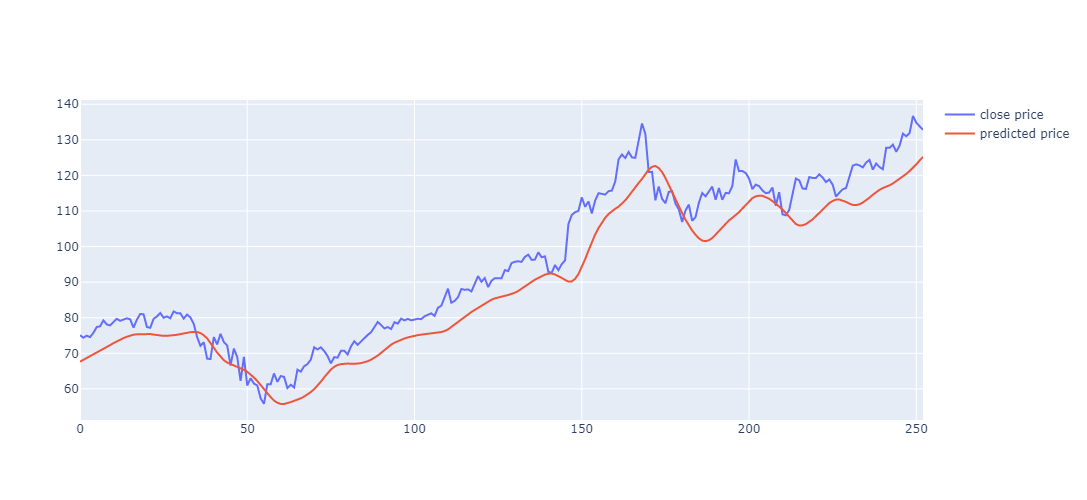

In [96]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=data_test['close'], name = 'close price'))
fig.add_trace(go.Scatter(y=predicted_prices[:, 0], name = 'predicted price'))
fig.update_layout(height=500, width=1000)
fig.show()

In [129]:
diff = np.array(data_test['close'].to_list()) - predicted_prices[:, 0]

In [130]:
diff[:10]

array([7.44938324, 6.24423828, 6.28270782, 5.37580872, 6.08059692,
       7.26831665, 6.97129425, 8.11656189, 6.41341156, 5.5317749 ])

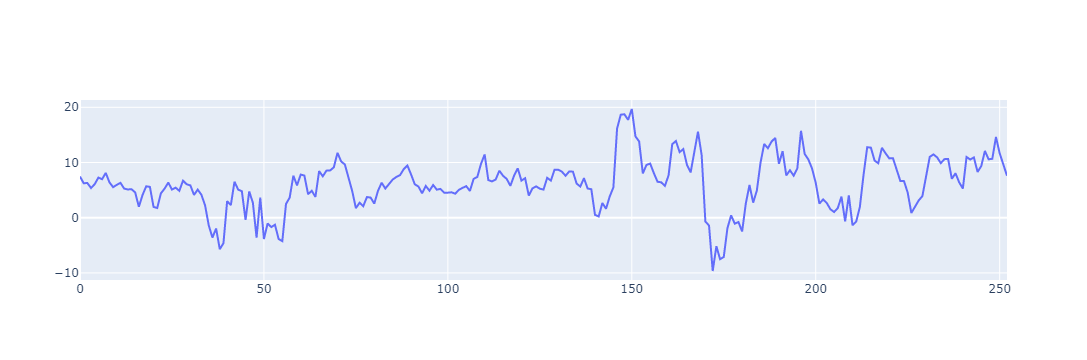

In [131]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=diff, name = 'close price'))
fig.show()